In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_data (data_path):
    data_dir_list = os.listdir(data_path)
    labels=[]
    data=[]
    num_class=0

    min_moy,min_var,min_max_diff,max_moy,max_var,max_max_diff=255,17000,255,0,0,0
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)    
        for img in img_list:
            
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            nb_pores,moyennes,variances,max_diff = extract_pores(input_img)
            if (moyennes != []) and (variances != []) and (max_diff != []):
                if min(moyennes)<min_moy:
                    min_moy = min(moyennes)
                if min(variances)<min_var:
                    min_var = min(variances)
                if min(max_diff)<min_max_diff:
                    min_max_diff = min(max_diff)
                if max(moyennes)>max_moy:
                    max_moy = max(moyennes)
                if max(variances)>max_var:
                    max_var = max(variances)
                if max(max_diff)>max_max_diff:
                    max_max_diff = max(max_diff)
                
                data.append([nb_pores,moyennes,variances,max_diff])
                labels.append(num_class)
        num_class+=1
    
    print(min_moy,min_var,min_max_diff,max_moy,max_var,max_max_diff)
    #normalisation des histogrammes
    
    norm_data=[] 
    for d in data:
        new_d = np.array(d[0])
        #moyennes de niveau de gris
        
        new_d = np.append(new_d,np.histogram(d[1],bins=15,range=(min_moy,max_moy))[0])
        #variances de niveau de gris
        new_d = np.append(new_d,np.histogram(d[2],bins=15,range=(min_var,max_var))[0])
        #max différence de niveau de gris
        new_d = np.append(new_d,np.histogram(d[3],bins=15,range=(min_max_diff,max_max_diff))[0])
        norm_data.append(new_d)

    norm_data = np.array(norm_data)
    print(norm_data)
    labels=np.array(labels)
    print('data shape',norm_data.shape)
    print('labels shape',labels.shape)
    return norm_data, labels

In [17]:
import math
def extract_pores(img):
    # (thresh, im_bw) = cv2.threshold(im, 128, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    thresh = 70
    im_bw = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]

    im_bw = abs(255-im_bw)

    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 1
    params.minDistBetweenBlobs = 1

    # # Set up the detector with default parameters.
    detector = cv2.SimpleBlobDetector_create(params)

    # # Detect blobs.
    keypoints = detector.detect(im_bw)

    moyennes = []
    variances = []
    max_diff = []
    
    for kp in keypoints:
        y,x = kp.pt
        win_kp = img[int(x)-2:int(x)+3,int(y)-2:int(y)+3]
        if math.isnan(np.mean(win_kp)):
            continue
        moyennes.append(np.mean(win_kp))
        variances.append(np.var(win_kp))
        max_diff.append(np.max(win_kp)-np.min(win_kp))

    

    moyennes = np.array(moyennes)
    variances = np.array(variances)
    max_diff = np.array(max_diff)

    return len(keypoints),moyennes,variances,max_diff

In [18]:
data_path='Datasets\Sagem_2011_merge'
data, labels=load_data (data_path) 

num_classes=2
Y = to_categorical(labels, num_classes)
X_train,y_train = shuffle(data,Y, random_state=2)
X_train, X_test, y_train , y_test = train_test_split(X_train,y_train, test_size=0.3, random_state=2)

C:\Users\nrozo\AppData\Local\Temp\ipykernel_6684\2770068507.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (moyennes != []) and (variances != []) and (max_diff != []):
C:\Users\nrozo\AppData\Local\Temp\ipykernel_6684\2770068507.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (moyennes != []) and (variances != []) and (max_diff != []):
C:\Users\nrozo\anaconda3\envs\sys809\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nrozo\anaconda3\envs\sys809\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7.88 2.32 6 211.44 9499.3056 241
[[ 223    0    3 ...   55   19    1]
 [ 175    0    2 ...   11    0    0]
 [  29    0    0 ...    0    0    0]
 ...
 [  43    0    0 ...    0    0    0]
 [  49    0    0 ...    0    0    0]
 [1457    0    0 ...    4    0    0]]
data shape (1440, 46)
labels shape (1440,)


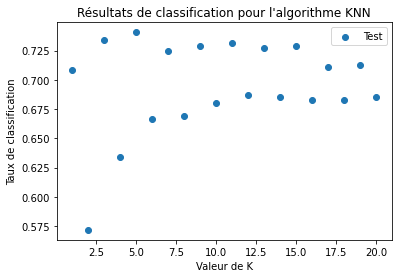

max score pour un nombre de 5 plus proches voisins : 0.7407407407407407


In [19]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 

kf = [i+1 for i in range(20)] # Préparation des valeurs de K dans une liste

scoreTest= []

for k in kf: # On itère sur les valeurs de K présentes dans Kf
  knn = KNeighborsClassifier(n_neighbors=k) 
  knn.fit(X_train, y_train) # Entraînement du modèle
  test_score = knn.score(X_test, y_test)
  scoreTest.append(test_score) # Stockage du score de test pour k donné

max_score_index = None
knn_max_score = 0
i = 1
for k in scoreTest:
    if (k > knn_max_score):
        max_score_index = i
        knn_max_score = k
    i += 1

x = kf
y_Test = scoreTest
plt.scatter(x, y_Test, label="Test") 
plt.xlabel("Valeur de K") 
plt.ylabel("Taux de classification")
plt.legend() 
plt.title("Résultats de classification pour l'algorithme KNN")
plt.show()

print("max score pour un nombre de", max_score_index, "plus proches voisins :",knn_max_score)

In [20]:
# #Pour classification d'une attaque non entrainée
# data_test_path='Datasets\Sagem_2011_only_gelatin'
# data_test, labels_test=load_data (data_test_path)



C:\Users\nrozo\AppData\Local\Temp\ipykernel_6684\2770068507.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (moyennes != []) and (variances != []) and (max_diff != []):
C:\Users\nrozo\AppData\Local\Temp\ipykernel_6684\2770068507.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (moyennes != []) and (variances != []) and (max_diff != []):


20.36 2.2655999999999996 6 216.08 5969.321600000001 235
[[ 21   0   0 ...   0   0   0]
 [ 28   0   0 ...   0   0   0]
 [194   0   0 ...   0   0   0]
 ...
 [305   0  12 ...   0   0   0]
 [223   1   9 ...   0   0   0]
 [312   0  12 ...   0   0   0]]
data shape (197, 46)
labels shape (197,)


In [22]:
# scoreTest= []
# predict = knn.predict(data_test)
# count_spoof = 0
# count_total = 0
# for p in predict:
#     if p[0]>p[1]:
#         count_spoof +=1
#     count_total += 1
# print('score :',float(count_spoof)/float(count_total))

score : 0.7258883248730964
